# Skin Cancer BT

## Install MONAI, updata fastai, any other installs go here

In [1]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"

In [2]:
pip install fastai==2.7.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.6/213.6 kB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.5.27
    Uninstalling fastcore-1.5.27:
      Successfully uninstalled fastcore-1.5.27
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.9
    Uninstalling fastai-2.7.9:
      Successfully uninstalled fastai-2.7.9
Note: you may need to restart the kernel to use updated packages.


In [3]:
#Other installs here
!pip install git+https://github.com/hamish-haggerty/base_rbt.git#egg='base_rbt'

  Cloning https://github.com/hamish-haggerty/base_rbt.git to /tmp/pip-install-gn59ld4p/base-rbt_b503a9b8490948a8abbc8807c3e9c132
  Running command git clone --filter=blob:none --quiet https://github.com/hamish-haggerty/base_rbt.git /tmp/pip-install-gn59ld4p/base-rbt_b503a9b8490948a8abbc8807c3e9c132
  Resolved https://github.com/hamish-haggerty/base_rbt.git to commit d756d018ff8fd90403720c4de6a0732a0298f4fd
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.1/569.1 kB 2.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 17.4 MB/s eta 0:00:00
  Created wheel for base_rbt: filename=base_rbt-0.0.1-py3-none-any.whl size=16049 sha256=81a4c55ebb47b9501d9330dfdb5446cd456a0dc34fb9c813dd48aa0fb9f4360e
  Stored in directory: /tmp/pip-ephem-wheel-cache-21bszcku/whee

## Imports

In [4]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import classification_report
import torch
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import *
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism
#print_config()

In [5]:
import fastai
from fastai.vision.all import *
#Other imports here

from base_rbt.base_model import * 
from base_rbt.base_lf import *
from base_rbt.base_linear import *
from base_rbt.helper import *

import self_supervised
import torch
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *

fastai.__version__

'2.7.10'

## Read image filenames from the dataset folders

In [6]:
train_dir='../input/skin-cancer-isic/skin_cancer_ISIC/Train'
test_dir='../input/skin-cancer-isic/skin_cancer_ISIC/Test'

In [7]:
#train
class_names0 = os.listdir(train_dir)
class_names = sorted(class_names0)
num_class = len(class_names)
image_files = [[os.path.join(train_dir, class_name, x) 
               for x in os.listdir(os.path.join(train_dir, class_name))] 
               for class_name in class_names]

image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)

## Now get the training data and validation data etc

In [8]:
#Helper functions to extract class names from the filenames
import re
def extract_text(string):
    # Use the compile method to create a RegexObject
    pattern = re.compile(r'/Train/(.*?)/ISIC')

    # Use the search method of the RegexObject to find the pattern in the string
    match = pattern.search(string)

    # If a match is found, return the matched text
    if match:
        return match.group(1)
    # If no match is found, return None
    else:
        
        return None

def label_func(x): return extract_text(x.as_posix())

#files names
fnames = get_image_files(train_dir)

#Extract training set
max_num =100 #maximum number of samples in each class
count_dict = {i:0 for i in class_names}
fnames_train = []
for i in fnames:
    #st=extract_text(i.as_posix())
    st=label_func(i)
    
    if count_dict[st]<max_num: #no more than 100 samples per category
        fnames_train.append(i)
        count_dict[st]+=1
                
#We further partition fnames_train into a tune-valiation set
count_dict2 = {i:0 for i in class_names}
fnames_tune = []
for i in fnames_train:
    st = label_func(i)
    if count_dict2[st] < 0.8*count_dict[st]:
        fnames_tune.append(i)
        count_dict2[st]+=1
        
def get_difference(x1, x2):
    return list(set(x1) - set(x2))

fnames_valid = get_difference(fnames_train,fnames_tune)

fnames_test = get_difference(fnames,fnames_train) + get_image_files(test_dir)

#sanity check
def display_dict(_fnames):
    
    _labels = [label_func(i) for i in _fnames]
    tem_dict = {i:_labels.count(i) for i in _labels}
    return tem_dict

tem_dict = display_dict(fnames)
print(f'The "original" training set: \n {tem_dict}\n')

tem_dict = display_dict(fnames_train)
print(f'Training set: used to train BT etc i.e. viewed as unlabelled \n {tem_dict}\n')

print('The training set is partitioned into tune-valid sets, with ~ 80-20 split\n')

tem_dict = display_dict(fnames_tune)
print(f'Tune set: used to train classifiers on representations \n {tem_dict}\n')

tem_dict = display_dict(fnames_valid)
print(f'Valid set: used to validate the classifiers trained above \n {tem_dict}\n')

tem_dict = display_dict(fnames_test)
print(f'Test set: only examine at the very end {tem_dict}\n')


The "original" training set: 
 {'pigmented benign keratosis': 462, 'melanoma': 438, 'vascular lesion': 139, 'actinic keratosis': 114, 'squamous cell carcinoma': 181, 'basal cell carcinoma': 376, 'seborrheic keratosis': 77, 'dermatofibroma': 95, 'nevus': 357}

Training set: used to train BT etc i.e. viewed as unlabelled 
 {'pigmented benign keratosis': 100, 'melanoma': 100, 'vascular lesion': 100, 'actinic keratosis': 100, 'squamous cell carcinoma': 100, 'basal cell carcinoma': 100, 'seborrheic keratosis': 77, 'dermatofibroma': 95, 'nevus': 100}

The training set is partitioned into tune-valid sets, with ~ 80-20 split

Tune set: used to train classifiers on representations 
 {'pigmented benign keratosis': 80, 'melanoma': 80, 'vascular lesion': 80, 'actinic keratosis': 80, 'squamous cell carcinoma': 80, 'basal cell carcinoma': 80, 'seborrheic keratosis': 62, 'dermatofibroma': 76, 'nevus': 80}

Valid set: used to validate the classifiers trained above 
 {'basal cell carcinoma': 20, 'squam

## Now get the training dataloader and view the data

In [9]:
#get data

#TODO: We can probably avoid these dataloaders?

device ='cuda' if torch.cuda.is_available() else 'cpu'

bs=256
size=128
n_in=3
numfit=200
ps=1024

item_tfms = [Resize(size)]

dls_train  = ImageDataLoaders.from_path_func(train_dir, fnames_train, label_func,
                                      bs=bs,
                                      item_tfms=item_tfms,
                                      valid_pct=0,
                                      device=device
                                    )
x,y = dls_train.one_batch()

dls_tune = ImageDataLoaders.from_path_func(train_dir, fnames_tune, label_func,
                                      bs=len(fnames_valid),
                                      item_tfms=item_tfms,
                                      valid_pct=0,
                                      device=device
                                    )
xtune,ytune = dls_tune.one_batch()

dls_valid  = ImageDataLoaders.from_path_func(train_dir, fnames_valid, label_func,
                                      bs=len(fnames_valid),
                                      item_tfms=item_tfms,
                                      valid_pct=0,
                                      device=device
                                    )
xval,yval = dls_valid.one_batch()

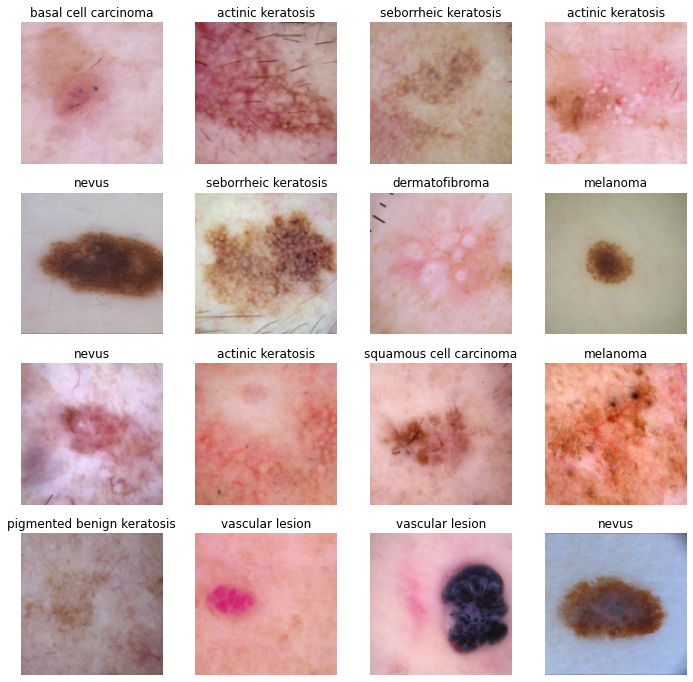

In [11]:
dls_train.show_batch(max_n=16)

## BT stuff now!

In [10]:
@patch
def lf(self:BarlowTwins, pred,*yb): return lf_bt(pred,I=self.I,lmb=self.lmb)

In [11]:
#Compute the mean and standard deviation of the dataset: 
def compute_mean_std(dls):
    # Initialize variables to store the sum and sum of squares of the data
    channel_sum = [0, 0, 0]
    channel_sum_squares = [0, 0, 0]

    # Iterate over the data in the dataloader
    for data,y in dls:
        
        batch_size, _, height, width = data.shape

        # Compute the sum and sum of squares of the data for each channel
        for channel in range(3):
            channel_sum[channel] += data[:, channel, :, :].sum()
            channel_sum_squares[channel] += (data[:, channel, :, :] ** 2).sum()

    # Calculate the number of elements in the data
    num_elements = batch_size * height * width * len(dls)

    # Calculate the mean and standard deviation for each channel
    means = [(channel_sum[i] / num_elements).item() for i in range(3)]
    stddevs = [(((channel_sum_squares[i] / num_elements) - means[i]**2)**0.5).item() for i in range(3)]

    return means, stddevs

means, stddevs = compute_mean_std(dls_train.train)

isic_stats_128 = means,stddevs #when shape is 128
print("Means:", means)
print("Standard deviations:", stddevs)

#Normalize.from_stats(mean=means,std=stddevs)

Means: [0.7616133093833923, 0.5861757397651672, 0.59127277135849]
Standard deviations: [0.12057309597730637, 0.1408204734325409, 0.15745460987091064]


In [18]:
isic_stats_128

([0.7609121799468994, 0.5869480967521667, 0.5924641489982605],
 [0.12186530977487564, 0.14097826182842255, 0.15697918832302094])

Ok, there is now a question of which augmentations to use...

In [36]:
#weird
# import kornia
# rng = torch.manual_seed(0)
# input = torch.rand(1, 1, 5, 5)
# blur = kornia.augmentation.RandomGaussianBlur((3, 3), (0.1, 3.0), p=1.)
# blur(input)
# print(input)
# tensor([[[[0.6699, 0.4645, 0.3193, 0.1741, 0.1955],
#           [0.5422, 0.6657, 0.6261, 0.6527, 0.5195],
#           [0.3826, 0.2638, 0.1902, 0.1620, 0.2141],
#           [0.6329, 0.6732, 0.5634, 0.4037, 0.2049],
#           [0.8307, 0.6753, 0.7147, 0.5768, 0.7097]]]])

tensor([[[[0.4963, 0.7682, 0.0885, 0.1320, 0.3074],
          [0.6341, 0.4901, 0.8964, 0.4556, 0.6323],
          [0.3489, 0.4017, 0.0223, 0.1689, 0.2939],
          [0.5185, 0.6977, 0.8000, 0.1610, 0.2823],
          [0.6816, 0.9152, 0.3971, 0.8742, 0.4194]]]])


tensor([[[[0.6699, 0.4645, 0.3193, 0.1741, 0.1955],
          [0.5422, 0.6657, 0.6261, 0.6527, 0.5195],
          [0.3826, 0.2638, 0.1902, 0.1620, 0.2141],
          [0.6329, 0.6732, 0.5634, 0.4037, 0.2049],
          [0.8307, 0.6753, 0.7147, 0.5768, 0.7097]]]])

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.5, 's': 11, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.5, 's': 11, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


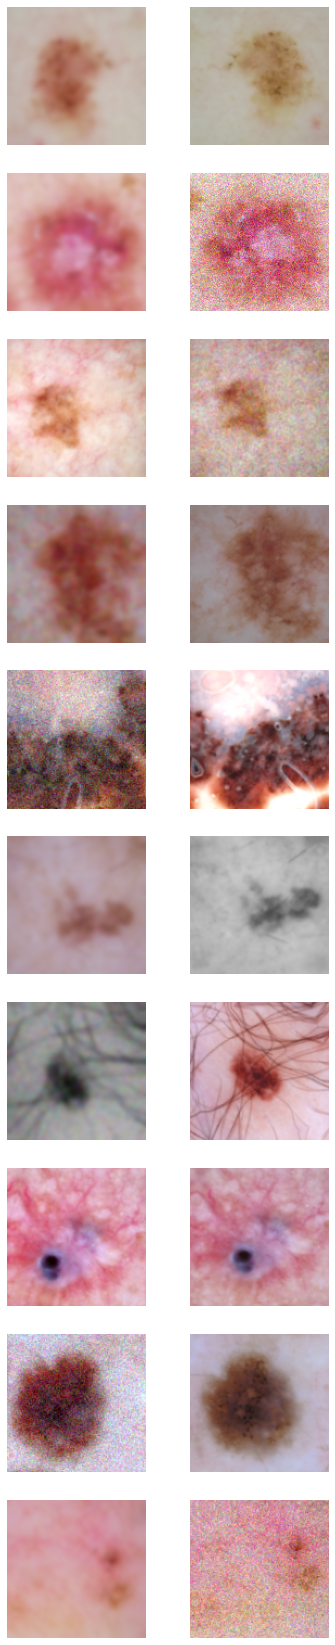

In [71]:
#Ok, there is now a huge question of which augmentations to apply!!!

#This had shit performance.

#Moral: Maybe too much noise?
aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=size,blur_r=(0.1,2),
                    rotate=True,jitter=True,noise=True,bw=True,blur=True,solar=True, #Whether to use aug or not
                    resize_scale=(0.7, 1.0),resize_ratio=(3/4, 4/3),noise_std=0.1, rotate_deg=20,blur_s=11,sol_t=0.025,sol_a=0.025, #hps of augs
                    flip_p=0.1, rotate_p=0.75,noise_p=0.25, jitter_p=0.5, bw_p=0.1, blur_p=0.5,sol_p=0.05, #prob of performing aug
                    same_on_batch=False,stats=None, cuda=(device=='cuda'))



#This was superior
# aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=size,blur_r=(0.5,2),
#                     rotate=True,jitter=True,noise=True,bw=True,blur=True,solar=True, #Whether to use aug or not
#                     resize_scale=(0.7, 1.0),resize_ratio=(3/4, 4/3),noise_std=0.05, rotate_deg=20,blur_s=11,sol_t=0.025,sol_a=0.025, #hps of augs
#                     flip_p=0.1, rotate_p=0.75,noise_p=0.25, jitter_p=0.25, bw_p=0.05, blur_p=0.25,sol_p=0.05, #prob of performing aug
#                     same_on_batch=False,stats=isic_stats_128, cuda=(device=='cuda'))



aug_pipelines = [aug_pipelines_1,aug_pipelines_1]

#View the augmentations the "usual way"
show_bt_batch(dls=dls_train,n_in=3,aug=aug_pipelines,n=10,print_augs=True)

## Train BT

In [72]:
fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)
model = create_barlow_twins_model(fastai_encoder, hidden_size=ps,projection_size=ps,nlayers=3)
learn = Learner(dls_train,model, cbs=[BarlowTwins(aug_pipelines,n_in=n_in,lmb=1/ps,print_augs=False)])
learn.fit(300)

epoch,train_loss,valid_loss,time
0,509.774384,None,00:25
1,378.765381,None,00:26
2,330.840668,None,00:25
3,302.415161,None,00:25
4,282.758301,None,00:25
5,266.088104,None,00:24
6,255.542603,None,00:24
7,244.677719,None,00:25
8,234.356430,None,00:25
9,225.295013,None,00:25


Your generator is empty.


In [36]:
#clone model 
import pickle
copyed_model = pickle.loads(pickle.dumps(model))

In [ ]:
#17.4250

## Linear evaluation / fine tuning:


Pipeline: RandomResizedCrop
Pipeline: 


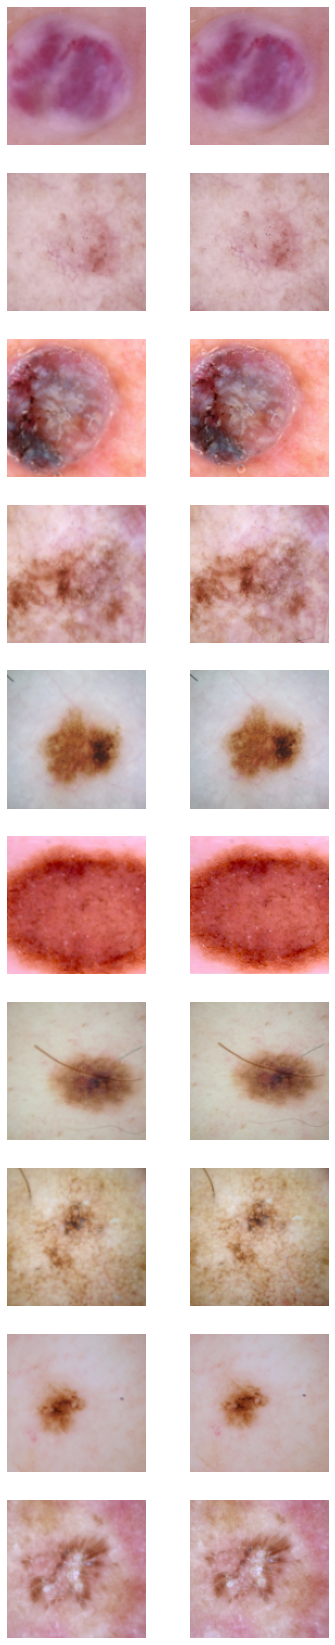

In [20]:
#Something weird goes on with normalization...

numfit=200
n_in=3

criterion = nn.CrossEntropyLoss()

isic_stats_128 = ([0.7609121799468994, 0.5869480967521667, 0.5924641489982605],[0.12186530977487564, 0.14097826182842255, 0.15697918832302094])
#stats = cifar_stats

aug_pipelines_tune=[get_linear_batch_augs(size=size,stats=None,resize=True,resize_scale=(0.7, 1.0),resize_ratio=(3/4, 4/3))]

show_linear_batch(dls=dls_tune,n_in=n_in,n=10,aug=aug_pipelines_tune,print_augs=True)

In [39]:
torch.optim.AdamW

torch.optim.adamw.AdamW

In [45]:
#fine tune standard xresnet (pre-trained!) on the raw pixels
def fit_model(x,y,model,weight_decay=0):
    
    #opt = Adam(model.parameters(),lr=0.001)
    
    opt = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=weight_decay)
    

    #opt_func = partial(optim.Adam, lr=0.001, weight_decay=0.0005)

 
    for epoch in range(numfit):

        x = aug_pipelines_tune[0](x) #augmentation
        out = model(x)
        loss = criterion(out,y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        #print(loss)
        
    return model

@torch.no_grad()
def predict_model(xval,yval,model):
    
    #need accuracy, also so F1 score and whatever other stuff we need...
    model.eval()
    
    test_eq(model.encoder.training,False)
    
    N=xval.shape[0]
    ypred=model(xval)
    correct = (torch.argmax(ypred,dim=1) == yval).type(torch.FloatTensor)
    num_correct = correct.sum()
    accuracy = num_correct/N
    return accuracy.item()
    
if __name__ == '__main__':
    
    #encoder = pickle.loads(pickle.dumps(fastai_encoder)) #copy
    
    #Just do linear evaluation...
    #encoder = grad_on(encoder,on=False)
    #encoder.eval()
    acc_dict={}
    wd = [0.2]
    
    for weight_decay in wd:
    
        acc_dict={}
        for i in range(10):

            encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)
            model = LinearModel(encoder=encoder,indim=1024,outdim=9).cuda() #composition of encoder and linear head
            model = fit_model(xtune,ytune,model,weight_decay=weight_decay)

            acc = predict_model(xval,yval,model)

            acc_dict[i] = acc

            print(f'Accuracy is {acc}') #Accuracy is 0.32758620381355286

        acc_dict['mean'] = (sum(list(acc_dict.values()))/len(acc_dict.values()))
        acc_dict['weight_decay'] = weight_decay

        print(acc_dict)

Accuracy is 0.23563218116760254
Accuracy is 0.25287356972694397
Accuracy is 0.18965516984462738
Accuracy is 0.2068965584039688
Accuracy is 0.18390804529190063
Accuracy is 0.20114941895008087
Accuracy is 0.2586206793785095
Accuracy is 0.2586206793785095
Accuracy is 0.16091954708099365
Accuracy is 0.26436781883239746
{0: 0.23563218116760254, 1: 0.25287356972694397, 2: 0.18965516984462738, 3: 0.2068965584039688, 4: 0.18390804529190063, 5: 0.20114941895008087, 6: 0.2586206793785095, 7: 0.2586206793785095, 8: 0.16091954708099365, 9: 0.26436781883239746, 'mean': 0.22126436680555345, 'weight_decay': 0.2}


Baseline results for pytorch Adam optimizer. We are just varying the weight decay parameter. 

In [ ]:
#So, best weight decay is ~ 0.2.
{0: 0.17241379618644714, 1: 0.18965516984462738, 2: 0.18965516984462738, 3: 0.21264368295669556, 4: 0.1551724076271057, 'mean': 0.18390804529190063, 'weight_decay': 0}

{0: 0.23563218116760254, 1: 0.24137930572032928, 2: 0.20114941895008087, 3: 0.19540229439735413, 4: 0.24137930572032928, 'mean': 0.22298850119113922, 'weight_decay': 0.01}

{0: 0.18390804529190063, 1: 0.2068965584039688, 2: 0.26436781883239746, 3: 0.18965516984462738, 4: 0.2298850566148758, 'mean': 0.21494252979755402, 'weight_decay': 0.1}

#(best, so repeat)
{0: 0.2183908075094223, 1: 0.2586206793785095, 2: 0.24137930572032928, 3: 0.22413793206214905, 4: 0.2586206793785095, 'mean': 0.24022988080978394, 'weight_decay': 0.2}

#still best, but lower
{0: 0.2068965584039688, 1: 0.24712643027305603, 2: 0.2183908075094223, 3: 0.21264368295669556, 4: 0.24712643027305603, 'mean': 0.22643678188323973, 'weight_decay': 0.2}

{0: 0.2298850566148758, 1: 0.17241379618644714, 2: 0.18390804529190063, 3: 0.20114941895008087, 4: 0.21264368295669556, 'mean': 0.2, 'weight_decay': 0.3}

Baseline results for pytorch AdamW optimizer. We are just varying the weight decay parameter. 

In [ ]:
{0: 0.18965516984462738, 1: 0.20114941895008087, 2: 0.14367815852165222, 3: 0.17241379618644714, 4: 0.19540229439735413, 'mean': 0.18045976758003235, 'weight_decay': 0.0}

{0: 0.2298850566148758, 1: 0.24712643027305603, 2: 0.17241379618644714, 3: 0.20114941895008087, 4: 0.13793103396892548, 'mean': 0.19770114719867707, 'weight_decay': 0.01}

{0: 0.1781609207391739, 1: 0.22413793206214905, 2: 0.21264368295669556, 3: 0.14942528307437897, 4: 0.23563218116760254, 'mean': 0.2, 'weight_decay': 0.1}

{0: 0.18390804529190063, 1: 0.22413793206214905, 2: 0.24137930572032928, 3: 0.1781609207391739, 4: 0.24137930572032928, 'mean': 0.21379310190677642, 'weight_decay': 0.2}

{0: 0.17241379618644714, 1: 0.21264368295669556, 2: 0.19540229439735413, 3: 0.22413793206214905, 4: 0.19540229439735413, 'mean': 0.2, 'weight_decay': 0.3}


Summary: So best weight decay parameter ~ 0.2, and Adam was better that AdamW (or at least, no worse).

The search was average over 5 runs. Now we do 10 runs to get a better idea of this baseline:

## Baseline:

In [ ]:
#mean is 0.2212 with a fair amount of variation
{0: 0.23563218116760254, 1: 0.25287356972694397, 2: 0.18965516984462738, 3: 0.2068965584039688, 4: 0.18390804529190063, 5: 0.20114941895008087, 6: 0.2586206793785095, 7: 0.2586206793785095, 8: 0.16091954708099365, 9: 0.26436781883239746, 'mean': 0.22126436680555345, 'weight_decay': 0.2}

Ok, first order of business is to establish baselines in the purely supervised setting. Otherwise, how do we know if we are doing better?

This shouldn't take too long. Get some nice 'permanent' results here. 

Then we can think about how to methodically search for good augmentations to use.

Ideas for this (perhaps read literature first?)

(Aside from crop etc)
- Just blur (several diff levels)
- Just noise (several diff levels)
- Just jitter (several diff levels)

Depending on above:

- Just blur and noise

- Then try everything?

There is combinatorial explosion here, so we need to think about what is an intelligent way of searching...




Here is one idea on how to start

- Just blur (a little; lots; then go from there)
- Just noise (a little; lots; then for from there)

- Their composition

- Then we have "optimal levels" of noise and blur; we can then try adding other augmentations...





Another idea on how to start: Just use ImageNet defaults?